In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)
n_clients = 2000
months = 6

# Crear IDs de clientes
client_ids = [f"C{str(i).zfill(5)}" for i in range(n_clients)]

# Crear historial mensual
data = []
for client in client_ids:
    age = np.random.randint(25, 75)
    country = np.random.choice(['France', 'Germany', 'Spain'])
    gender = np.random.choice(['Male', 'Female'])
    base_balance = np.random.normal(100000, 30000)
    churn_prob = np.random.rand()
    
    for month in range(1, months + 1):
        balance = base_balance + np.random.normal(0, 5000)
        salary = np.random.normal(70000, 10000)
        products = np.random.randint(1, 4)
        is_active = np.random.binomial(1, 0.7)
        card = np.random.binomial(1, 0.5)
        complaints = np.random.poisson(0.2)
        
        data.append({
            'ClientID': client,
            'Month': month,
            'Age': age,
            'Gender': gender,
            'Geography': country,
            'Balance': balance,
            'Salary': salary,
            'NumOfProducts': products,
            'IsActiveMember': is_active,
            'HasCrCard': card,
            'Complaints': complaints,
            'Exited': 1 if (month == months and churn_prob > 0.7) else 0
        })

df = pd.DataFrame(data)


In [2]:
# Agregar información mensual por cliente
agg_df = df.groupby('ClientID').agg({
    'Age': 'first',
    'Gender': 'first',
    'Geography': 'first',
    'Balance': ['mean', 'std'],
    'Salary': 'mean',
    'NumOfProducts': 'mean',
    'IsActiveMember': 'mean',
    'HasCrCard': 'mean',
    'Complaints': 'sum',
    'Exited': 'max'
})

agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
agg_df.reset_index(inplace=True)


In [3]:
# Convertir categóricas
agg_df['Gender_first'] = agg_df['Gender_first'].map({'Female': 1, 'Male': 0})
agg_df = pd.get_dummies(agg_df, columns=['Geography_first'], drop_first=True)

# Separar variables
X = agg_df.drop(['ClientID', 'Exited_max'], axis=1)
y = agg_df['Exited_max']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.65      0.83      0.73       266
           1       0.23      0.10      0.14       134

    accuracy                           0.58       400
   macro avg       0.44      0.47      0.44       400
weighted avg       0.51      0.58      0.53       400



/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:22:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329020674/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


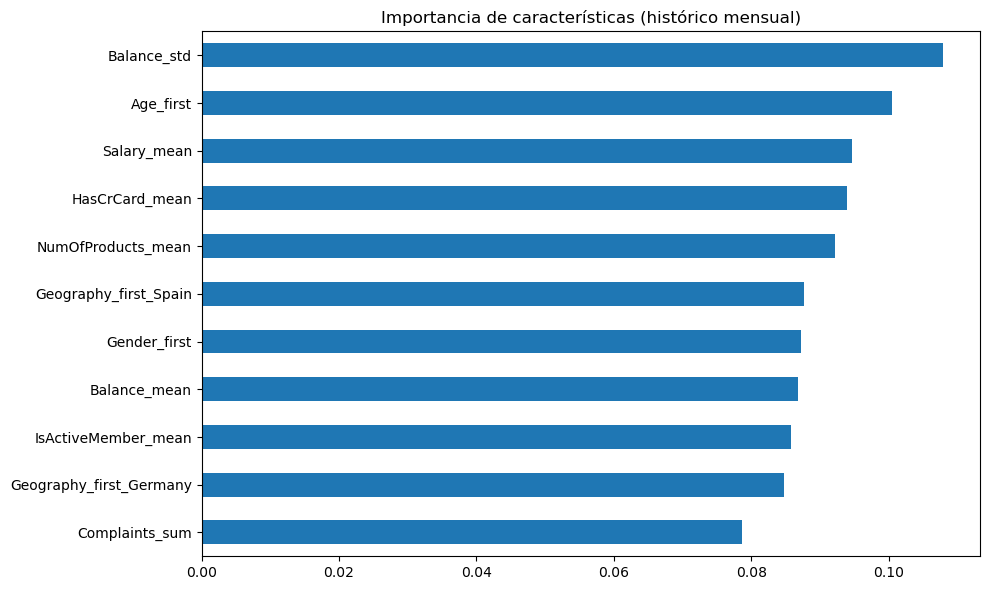

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

importance = pd.Series(model.feature_importances_, index=X.columns)
importance.sort_values(ascending=True).plot(kind='barh', figsize=(10, 6))
plt.title("Importancia de características (histórico mensual)")
plt.tight_layout()
plt.show()
